# Set Up Notebook

In [1]:
###########
# IMPORTS #
###########

# System and file handling
import os
from pathlib import Path

# Data processing and math
import pandas as pd
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Display
from IPython.display import display, HTML


#################
# CONFIGURATION #
#################

# Set path to corpus directory
base_path = r'/Users/amb/Desktop/Verschwörungserzählungen/Corpus'

# Configure global display settings for pandas
pd.options.display.float_format = '{:,.4f}'.format


#########################
# CONSPIRACY CATEGORIES #
#########################

# Map keywords to categories
conspiracy_categories = {
    "Shadowy Agents": ["elite*", "illuminati*", "cabal*", "syndicate*", "establishment", "deep state", "agency", "secret society", "fib", "iaa", "epsilon", "omega"],
    "Deception": ["manipulate*", "cover-up", "hoax", "fake", "staged", "poison*", "brainwash*", "indoctrinate*", "plot*", "scheme*"],
    "Hidden Truth": ["truth", "awake*", "sheep*", "blind", "hidden", "classified", "unveil*", "red pill", "eyes open", "watching"],
    "Narrative Motifs": ["alien*", "ufo*", "abduction*", "experiment*", "surveillance", "tracking", "chip*", "satellite*", "radiation", "chemtrail*"]
}


#########
# GAMES #
#########

# Define order
ordered_games = [
    "Grand Theft Auto (1997)",
    "Grand Theft Auto 2 (1999)",
    "Grand Theft Auto III (2001)",
    "Grand Theft Auto: Vice City (2002)",
    "Grand Theft Auto: San Andreas (2004)",
    "Grand Theft Auto Advance (2004)",
    "Grand Theft Auto: Liberty City Stories (2005)",
    "Grand Theft Auto: Vice City Stories (2006)",
    "Grand Theft Auto IV (2008)",
    "Grand Theft Auto IV: The Lost and Damned (2009)",
    "Grand Theft Auto IV: The Ballad of Gay Tony (2009)",
    "Grand Theft Auto: Chinatown Wars (2009)",
    "Grand Theft Auto V (2013)"
]

# Map abbreviations to games
short_names_map = {
    "Grand Theft Auto (1997)": "GTA 1 (1997)",
    "Grand Theft Auto 2 (1999)": "GTA 2 (1999)",
    "Grand Theft Auto III (2001)": "GTA III (2001)",
    "Grand Theft Auto: Vice City (2002)": "GTA: VC (2002)",
    "Grand Theft Auto: San Andreas (2004)": "GTA: SA (2004)",
    "Grand Theft Auto Advance (2004)": "GTA Advance (2004)",
    "Grand Theft Auto: Liberty City Stories (2005)": "GTA: LCS (2005)",
    "Grand Theft Auto: Vice City Stories (2006)": "GTA: VCS (2006)",
    "Grand Theft Auto IV (2008)": "GTA IV (2008)",
    "Grand Theft Auto IV: The Lost and Damned (2009)": "GTA: TLAD (2009)",
    "Grand Theft Auto IV: The Ballad of Gay Tony (2009)": "GTA: TBoGT (2009)",
    "Grand Theft Auto: Chinatown Wars (2009)": "GTA: CTW (2009)",
    "Grand Theft Auto V (2013)": "GTA V (2013)"
}

# Map titles to folder names
folder_mapping = {
    "gta": "Grand Theft Auto (1997)",
    "gta 2": "Grand Theft Auto 2 (1999)",
    "gta iii": "Grand Theft Auto III (2001)",
    "gta vc": "Grand Theft Auto: Vice City (2002)",
    "gta sa": "Grand Theft Auto: San Andreas (2004)",
    "gta advance": "Grand Theft Auto Advance (2004)",
    "gta lcs": "Grand Theft Auto: Liberty City Stories (2005)",
    "gta vcs": "Grand Theft Auto: Vice City Stories (2006)",
    "gta iv": "Grand Theft Auto IV (2008)",
    "gta ctw": "Grand Theft Auto: Chinatown Wars (2009)",
    "gta v": "Grand Theft Auto V (2013)"
}

def get_game_label(path_string):
    """
    Identifies game title from file path.
    Handles DLC separation for GTA IV.
    Maps titles to folder names.
    """
    
    # Normalize paths
    p = str(path_string).lower().replace('\\', '/')
    
    # Check for DLCs
    if 'tlad' in p:
        return "Grand Theft Auto IV: The Lost and Damned (2009)"
    if 'tbogt' in p:
        return "Grand Theft Auto IV: The Ballad of Gay Tony (2009)"
    
    # Extract folder names
    parts = p.split('/')
    
    for part in parts:
        if part in folder_mapping:
            return folder_mapping[part]
    
    return "Unknown"


############
# CLEANING #
############
def is_technical_string(text):
    """Filters technical artifacts."""
    if '_' in text: return True
    if len(text) > 1 and text.isupper(): return True
    if re.fullmatch(r'[\d\W_]+', text): return True
    return False

def extract_game_text(line, ext):
    """Extracts and cleans text based on file extension."""
    line = line.strip()

    # Skip header
    if not line or line in ['{', '}', 'Version'] or line.startswith(('CharSize', 'NeedDecode', 'SingleFileTable')):
        return None
    
    text = None
    if ext == '.oxt':
        if '=' in line: text = line.split('=', 1)[1].strip()
    elif ext == '.txt':
        if line.startswith('[') and line.endswith(']'): return None
        if '//' in line: text = line.split('//', 1)[1].strip()
        else: text = line
    elif ext == '.csv':
        parts = re.findall(r'"(.*?)"', line)
        if len(parts) >= 2:
            if parts[0].lower() in ['gxt', 'id', 'key']: return None
            text = parts[1]
            
    if text:
        
        # Remove markup
        text = re.sub(r'~.*?~|#|<<|>>', '', text).strip()
        
        # Remove technical strings
        if text and not is_technical_string(text):
            return text if len(text) > 1 else None
    return None


#############
# WILDCARDS #
#############
def wildcard_to_regex(wildcard_pattern):
    """Converts search patterns into searchable regex objects."""
    regex_str = r'\b' + re.escape(wildcard_pattern).replace(r'\*', r'\w*') + r'\b'
    return re.compile(regex_str, re.IGNORECASE)

# Describe Raw and Cleaned Corpus

In [2]:
def run_comparative_audit(root_dir):
    """
    Performs an audit to quantify noise reduction.
    Measures lines, characters, tokens, and lexical diversity.
    """
    
    # Initialize metric containers
    raw_stats = {'lines': 0, 'chars': 0, 'tokens': []}
    clean_stats = {'lines': 0, 'chars': 0, 'tokens': []}
    total_files = 0
    
    root_path = Path(root_dir)
    valid_extensions = {'.oxt', '.txt', '.csv'}
    
    # Collect data
    for file_path in root_path.rglob('*'):
        ext = file_path.suffix.lower()
        if ext in valid_extensions:
            total_files += 1
            try:
                with open(file_path, 'r', encoding = 'utf-8', errors = 'ignore') as f:
                    for line in f:
                        raw_line = line.strip()
                        if not raw_line: continue
                        
                        # Process raw data
                        raw_stats['lines'] += 1
                        raw_stats['chars'] += len(raw_line)
                        raw_stats['tokens'].extend(re.findall(r'\b\w+\b', raw_line.lower()))
                        
                        # Process cleaned data
                        clean_text = extract_game_text(line, ext)
                        if clean_text:
                            clean_stats['lines'] += 1
                            clean_stats['chars'] += len(clean_text)
                            clean_stats['tokens'].extend(re.findall(r'\b[a-zA-Z-]{2,}\b', clean_text.lower()))
            except Exception:
                pass
    
    # Calculate metrics
    def calculate_metrics(s):
        """Helps to calculate N (tokens), V (types), and TTR."""
        n = len(s['tokens'])
        v = len(set(s['tokens']))
        ttr = v / n if n > 0 else 0
        return [s['lines'], s['chars'], n, v, ttr]
    
    raw_vals = calculate_metrics(raw_stats)
    clean_vals = calculate_metrics(clean_stats)
    
    # Calculate difference
    diff_vals = [r - c for r, c in zip(raw_vals, clean_vals)]
    
    # Construct DataFrame
    df_comp = pd.DataFrame({
        'Metric': [
            'Lines', 
            'Characters', 
            'Tokens', 
            'Unique Word Types', 
            'Type-Token Ratio'
        ],
        'Raw': raw_vals,
        'Cleaned': clean_vals,
        'Difference': diff_vals
    })
    
    print(f"Audit complete. {total_files} files analyzed.")
    return df_comp

# Execute and display audit
audit_results = run_comparative_audit(base_path)

display(audit_results)

Audit complete. 950 files analyzed.


,Metric,Raw,Cleaned,Difference
0,Lines,"631,033.0000","367,301.0000","263,732.0000"
1,Characters,"27,877,767.0000","15,347,302.0000","12,530,465.0000"
2,Tokens,"4,131,031.0000","2,686,957.0000","1,444,074.0000"
3,Unique Word Types,"769,730.0000","45,697.0000","724,033.0000"
4,Type-Token Ratio,0.1863,0.0170,0.1693


# Build Master Corpus

In [3]:
def build_master_corpus(root_dir):
    """
    Aggregates cleaned text from all files into a single DataFrame.
    """
    all_data = []
    root_path = Path(root_dir)
    extensions = {'.oxt', '.txt', '.csv'}
        
    # Collect data
    for file_path in root_path.rglob('*'):
        ext = file_path.suffix.lower()
        if ext in extensions:
            
            # Create clean relative paths
            rel_path = str(file_path.relative_to(root_path)).replace('\\', '/')
            
            # Map game titles to paths
            game_title = get_game_label(rel_path)
            
            try:
                with open(file_path, 'r', encoding = 'utf-8', errors = 'ignore') as f:
                    for line in f:
                        
                        # Apply cleaning
                        text = extract_game_text(line, ext)
                        
                        if text:
                            all_data.append({
                                'Game': game_title,
                                'Path': rel_path,
                                'Text': text
                            })
            except Exception:
                pass
    
    return pd.DataFrame(all_data)

# Construct DataFrame
df_master = build_master_corpus(base_path)

# Export file
if not df_master.empty:
    output_file = "conspiracy_gta_master_corpus.csv"
    df_master.to_csv(output_file, index = False, encoding = 'utf-8-sig')
    
    print(f"Corpus saved to '{output_file}'.")
    
    # Display preview
    display(df_master.head(25))
else:
    print("No data found.")

Corpus saved to 'conspiracy_gta_master_corpus.csv'.


,Game,Path,Text
0,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Splitz-6 ATV
1,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Accuracy
2,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Admiral
3,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Air Ambulance
4,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,'Crims On Water Wings'
5,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,'Crims On Wings'
6,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Ambassador
7,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Ambulance
8,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Your Body Armor is in good condition.
9,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Cost: $


# Search for Keywords

In [4]:
# Configure search
search_patterns = ["alien*", "ufo*", "conspir*", "secret*", "government*", "fib", "iaa", "truth*"]
export_results_file = "conspiracy_gta_search_results.csv"

# Define Search
def perform_search(df, patterns):
    """
    Scans the DataFrame for keywords and returns hits.
    """
    hits = []
    regex_list = [(p, wildcard_to_regex(p)) for p in patterns]
        
    for _, row in df.iterrows():
        text = str(row['Text'])
        for original_pattern, regex in regex_list:
            match = regex.search(text)
            if match:
                hits.append({
                    'Game': row['Game'],
                    'Pattern': original_pattern,
                    'Match': match.group(0),
                    'Context': text,
                    'Path': row['Path']
                })
                
                # Break after first match in line to avoid redundancy
                break
    
    return pd.DataFrame(hits)

# Execute
if 'df_master' in locals() and not df_master.empty:
    df_hits = perform_search(df_master, search_patterns)
    
    if not df_hits.empty:
        
        # Export results
        df_hits.to_csv(export_results_file, index = False, encoding = 'utf-8-sig')
        
        print(f"Search complete; {len(df_hits):,} matches found.")
        print(f"Results exported to '{export_results_file}'.")
        
        # Display preview
        display(df_hits.head(25))
    else:
        print("No matches found.")
else:
    print("No data found.")

Search complete; 1,545 matches found.
Results exported to 'conspiracy_gta_search_results.csv'.


,Game,Pattern,Match,Context,Path
0,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,"Huang, When you've finished taking out that bo...",GTA CTW/gta_ctw.csv
1,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,"Huang, When you've finished taking out that bo...",GTA CTW/gta_ctw.csv
2,Grand Theft Auto: Chinatown Wars (2009),government*,government,"Dear Badger user,Have you checked out the Soci...",GTA CTW/gta_ctw.csv
3,Grand Theft Auto: Chinatown Wars (2009),government*,government,"Dear Badger user,Have you checked out the Soci...",GTA CTW/gta_ctw.csv
4,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,FIB building,GTA CTW/gta_ctw.csv
5,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,FIB building,GTA CTW/gta_ctw.csv
6,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,HestonThere they are! The Assassin's boss and ...,GTA CTW/gta_ctw.csv
7,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,HestonThere they are! The Assassin's boss and ...,GTA CTW/gta_ctw.csv
8,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,"There are two former allies I no longer trust,...",GTA CTW/gta_ctw.csv
9,Grand Theft Auto: Chinatown Wars (2009),fib,FIB,"There are two former allies I no longer trust,...",GTA CTW/gta_ctw.csv


# Calculate Further Metrics

In [5]:
def calculate_advanced_metrics(df):
    """
    Calculates linguistic density metrics.
    """
    
    # Collect all words
    word_pattern = re.compile(r'\b[a-zA-Z-]{2,}\b')
    
    # Create counters
    word_counts = Counter()
    line_word_counts = []
    total_chars_in_words = 0
    total_tokens = 0
        
    # Count
    for text in df['Text']:
        found_words = word_pattern.findall(str(text).lower())
        
        word_counts.update(found_words)
        total_tokens += len(found_words)
        line_word_counts.append(len(found_words))
        
        for w in found_words:
            total_chars_in_words += len(w)
    
    # Calculate hapax legomena
    hapax_list = [word for word, count in word_counts.items() if count == 1]
    n_hapax = len(hapax_list)
    vocabulary_size = len(word_counts)
    
    percentage_hapax = (n_hapax / vocabulary_size) * 100 if vocabulary_size > 0 else 0
    
    # Calculate average line length
    avg_line_length = sum(line_word_counts) / len(line_word_counts) if line_word_counts else 0
    
    # Calculate average word length
    avg_word_chars = total_chars_in_words / total_tokens if total_tokens > 0 else 0
    
    # Build result table
    metrics = [
        ("Total Tokens", total_tokens),
        ("Unique Types", vocabulary_size),
        ("Hapax Legomena", n_hapax),
        ("Percentage of Hapax Legomena", f"{percentage_hapax:.2f} %"),
        ("Average Line Length (Words)", f"{avg_line_length:.2f}"),
        ("Average Word Length (Characters)", f"{avg_word_chars:.2f}")
    ]
    
    return pd.DataFrame(metrics, columns = ['Metric', 'Value'])

# Execute
if 'df_master' in locals():
    df_adv_metrics = calculate_advanced_metrics(df_master)
    display(df_adv_metrics)
else:
    print("No data found.")

,Metric,Value
0,Total Tokens,2686957
1,Unique Types,45697
2,Hapax Legomena,16098
3,Percentage of Hapax Legomena,35.23 %
4,Average Line Length (Words),7.32
5,Average Word Length (Characters),4.44


# Calculate Lexical Density, Display Top Bigrams, and Generate Word Length Distribution Graph

Lexical density: 0.7762 (Ratio of content words to total words)
Top bigrams:
- "to the": 9137 times
- "in the": 7950 times
- "you re": 7097 times
- "of the": 6370 times
- "press to": 5846 times
- "on the": 5832 times
- "you can": 5019 times
- "this is": 3995 times
- "if you": 3720 times
- "you know": 3443 times
- "we re": 3323 times
- "to be": 3251 times
- "for the": 3075 times
- "are you": 3014 times
- "at the": 2936 times
- "out of": 2876 times
- "you have": 2661 times
- "to get": 2639 times
- "you are": 2539 times
- "come on": 2517 times
- "going to": 2510 times
- "want to": 2424 times
- "you want": 2377 times
- "will be": 2238 times
- "need to": 2219 times
Graph saved as 'conspiracy_gta_word_length_distribution.png'.


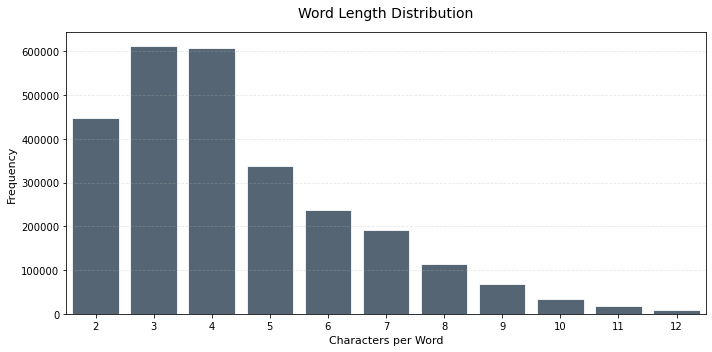

In [6]:
def run_lexical_fingerprint(df):
    """
    Analyzes bigrams, word length distribution, and lexical density.
    """
    all_tokens = []
    bigram_counts = Counter()
    
    # Pre-compile regex
    word_pattern = re.compile(r'\b[a-zA-Z-]{2,}\b')
    
    for text in df['Text']:
        # Clean and tokenize line by line
        line_tokens = word_pattern.findall(str(text).lower())
        all_tokens.extend(line_tokens)
        
        # Calculate bigrams
        if len(line_tokens) >= 2:
            line_bigrams = zip(line_tokens, line_tokens[1:])
            bigram_counts.update([f"{a} {b}" for a, b in line_bigrams])
    
    # Collect top 25 bigrams
    top_bigrams = bigram_counts.most_common(25)
    
    # Calculate word lengths
    word_lengths = [len(w) for w in all_tokens]
    len_dist = Counter(word_lengths)
    
    # Calculate lexical density
    stopwords = {"the", "a", "an", "and", "or", "but", "if", "then", "at", "by", 
                 "for", "with", "to", "of", "in", "on", "is", "was", "be", "it", "you", "that"}
    content_words_count = sum(1 for w in all_tokens if w not in stopwords)
    lex_density = content_words_count / len(all_tokens) if all_tokens else 0
    
    # Display results
    print(f"Lexical density: {lex_density:.4f} (Ratio of content words to total words)")
    print("Top bigrams:")
    for phrase, count in top_bigrams:
        print(f"- \"{phrase}\": {count} times")
    
    # Generate graph
    plt.figure(figsize = (10, 5))
    
    # Filter for word lengths (2 to 12 characters)
    plot_data = {length: len_dist[length] for length in range(2, 13)}
    
    plt.bar(plot_data.keys(), plot_data.values(), color = '#2c3e50', edgecolor = 'white', alpha = 0.8)
    
    plt.title('Word Length Distribution', fontsize = 14, pad = 15)
    plt.xlabel('Characters per Word', fontsize = 11)
    plt.ylabel('Frequency', fontsize = 11)
    
    plt.xticks(range(2, 13))
    plt.xlim(1.5, 12.5)
    
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.3)
    plt.tight_layout()
    
    plt.savefig('conspiracy_gta_word_length_distribution.png', dpi = 300)
    
    print("Graph saved as 'conspiracy_gta_word_length_distribution.png'.")

# Execute
if 'df_master' in locals():
    run_lexical_fingerprint(df_master)

# Generate Heatmap

Graph saved as 'conspiracy_gta_heatmap.png'.


Category,Shadowy Agents,Deception,Hidden Truth,Narrative Motifs
Grand Theft Auto (1997),0.6135,1.8405,5.5215,0.6135
Grand Theft Auto 2 (1999),0.4753,2.8517,1.9011,2.3764
Grand Theft Auto III (2001),0.0000,1.0304,3.6064,0.5152
Grand Theft Auto: Vice City (2002),1.0285,0.7714,1.7999,1.7999
Grand Theft Auto: San Andreas (2004),0.4466,0.7018,4.8485,3.5726
Grand Theft Auto: Liberty City Stories (2005),0.0000,0.5815,2.1322,0.5815
Grand Theft Auto: Vice City Stories (2006),0.0000,0.3259,1.4665,0.0000
Grand Theft Auto IV (2008),2.4888,1.3085,2.8480,0.7441
Grand Theft Auto IV: The Lost and Damned (2009),0.8218,0.2739,1.6437,0.4566
Grand Theft Auto IV: The Ballad of Gay Tony (2009),0.4292,0.5722,1.5737,0.6438


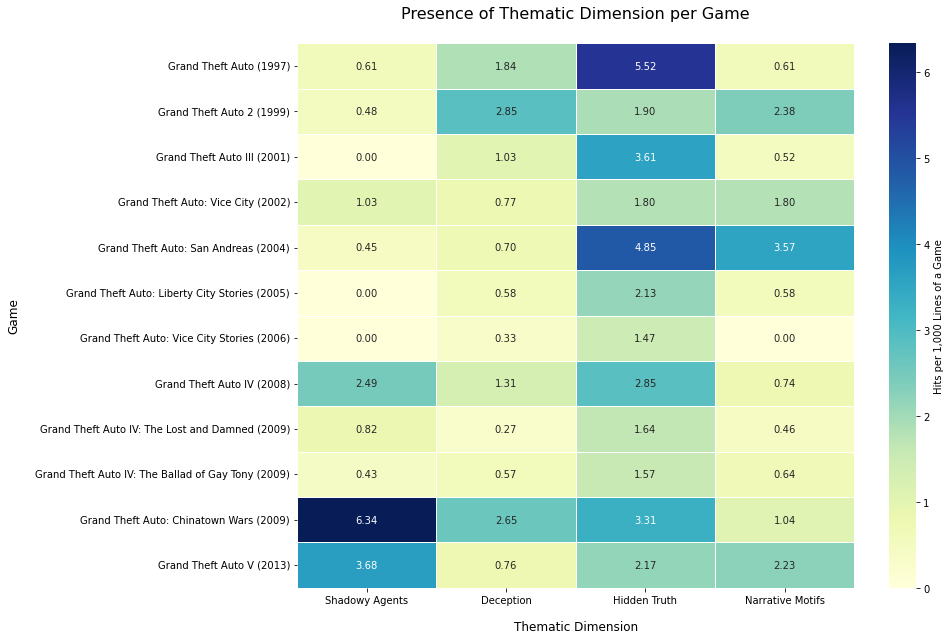

In [7]:
def run_heatmap(df):
    """
    Creates a normalized heatmap of conspiracy categories per game.
    Normalizes by line count to ensure comparability across games.
    """
    
    # Calculate totals
    game_totals = df['Game'].value_counts()
    
    # Define category order for x-axis
    category_order = ["Shadowy Agents", "Deception", "Hidden Truth", "Narrative Motifs"]
    
    # Prepare regex objects
    compiled_cats = {cat: [wildcard_to_regex(p) for p in patterns] for cat, patterns in conspiracy_categories.items()}
    
    results = []
        
    for cat, regexes in compiled_cats.items():
        combined_regex = re.compile("|".join([r.pattern for r in regexes]), re.IGNORECASE)
        mask = df['Text'].str.contains(combined_regex, na = False)
        
        # Get game labels
        hits = df.loc[mask, 'Game']
        for game in hits:
            results.append({'Game': game, 'Category': cat})
    
    df_hits = pd.DataFrame(results)
    if df_hits.empty:
        print("No matches found.")
        return
    
    # Create and normalize matrix
    matrix_abs = df_hits.groupby(['Game', 'Category']).size().unstack(fill_value = 0)
    matrix_rel = matrix_abs.divide(game_totals, axis = 0) * 1000
    
    # Order
    available_games = [g for g in ordered_games if g in matrix_rel.index]
    available_cats = [c for c in category_order if c in matrix_rel.columns]
    
    matrix_rel = matrix_rel.reindex(index = available_games, columns = available_cats).fillna(0)
    
    # Generate graph
    plt.figure(figsize = (14, 9))
    
    sns.heatmap(matrix_rel, annot = True, fmt = '.2f', cmap = 'YlGnBu',
                cbar_kws = {'label': 'Hits per 1,000 Lines of a Game'}, linewidths = .5)
    
    plt.title('Presence of Thematic Dimension per Game', fontsize = 16, pad = 25)
    plt.xlabel('Thematic Dimension', fontsize = 12, labelpad = 15)
    plt.ylabel('Game', fontsize = 12, labelpad = 15)
    
    plt.tight_layout()
    plt.savefig('conspiracy_gta_heatmap.png', dpi = 300)
    
    print("Graph saved as 'conspiracy_gta_heatmap.png'.")
    display(matrix_rel)

# Execute
if 'df_master' in locals() and not df_master.empty:
    run_heatmap(df_master)

# Generate Barcode for Thematic Dimensions

Graph saved as 'conspiracy_gta_barcode_dimensions.png'.


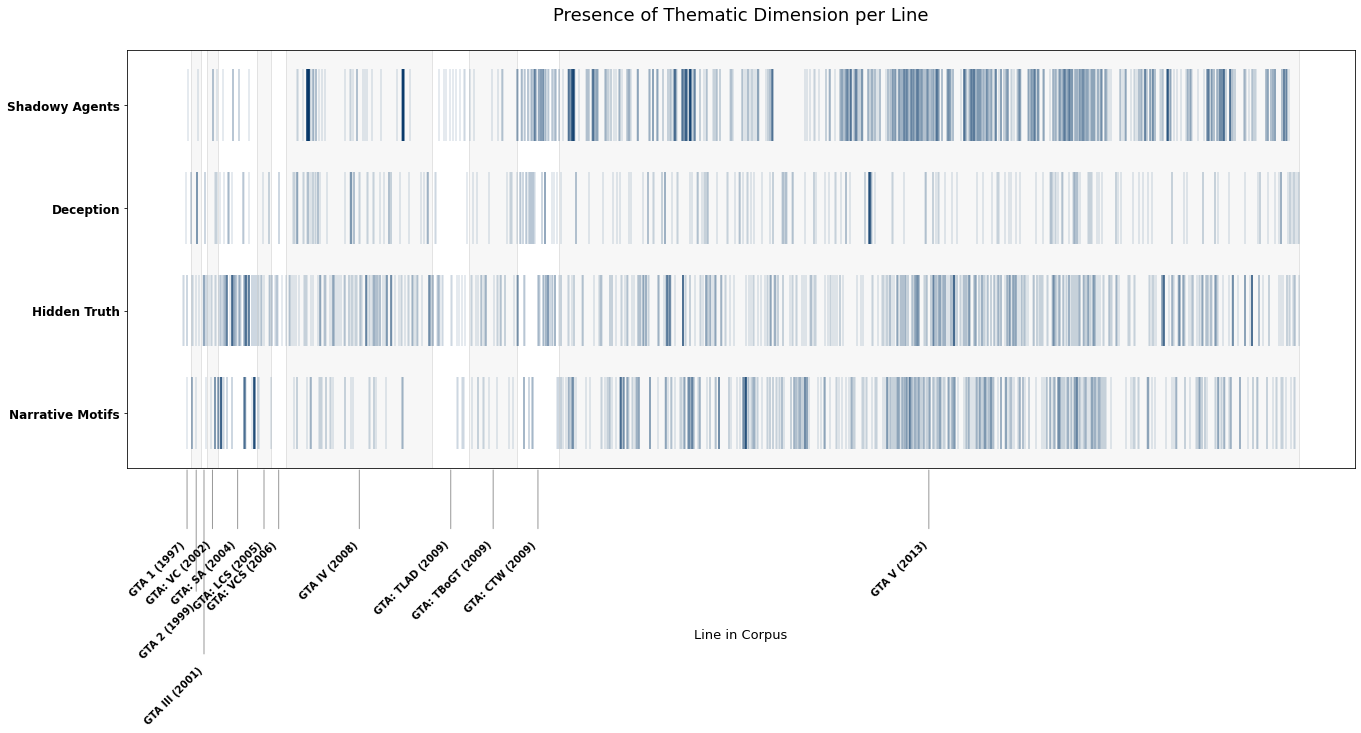

In [8]:
def run_barcode_dimensions(df, categories):
    """
    Creates a barcode of conspiracy categories for thematic dimensions.
    """
    
    # Order
    df_filtered = df[df['Game'].isin(ordered_games)].copy()
    df_filtered['Sort_Order'] = df_filtered['Game'].apply(lambda x: ordered_games.index(x))
    df_sorted = df_filtered.sort_values('Sort_Order').reset_index(drop = True)
    
    all_words = []
    game_boundaries = []
    current_game = None
    
    for i, row in df_sorted.iterrows():
        game = row['Game']
        if game != current_game:
            game_boundaries.append({'start': len(all_words), 'name': game})
            current_game = game
        
        tokens = re.findall(r'\b[a-zA-Z-]{2,}\b', str(row['Text']).lower())
        all_words.extend(tokens)
    
    total_len = len(all_words)
    
    # Set up graph
    category_names = list(categories.keys())
    fig, ax = plt.subplots(figsize = (22, 10))
    colors = ['#ffffff', '#f7f7f7']
    
    # Draw background and labels
    for i, boundary in enumerate(game_boundaries):
        start = boundary['start']
        end = game_boundaries[i + 1]['start'] if i + 1 < len(game_boundaries) else total_len
        short_name = short_names_map.get(boundary['name'], boundary['name'])
        
        ax.axvspan(start, end, facecolor = colors[i % 2], alpha = 1.0, zorder = 0)
        ax.axvline(x = end, color = '#dddddd', lw = 0.8, zorder = 1)
        
        drop_depth = -0.15 if i > 2 else [-0.15, -0.30, -0.45][i]
        mid = start + (end - start) / 2
        
        ax.annotate('', xy = (mid, 0), xycoords = ('data', 'axes fraction'),
                    xytext = (mid, drop_depth), textcoords = ('data', 'axes fraction'),
                    arrowprops = dict(arrowstyle = '-', color = '#999999', lw = 1))
        
        ax.text(mid, drop_depth - 0.02, short_name, transform = ax.get_xaxis_transform(),
                rotation = 45, ha = 'right', va = 'top', fontsize = 10, fontweight = 'bold')

    # Draw bars
    for idx, (cat_name, patterns) in enumerate(reversed(list(categories.items()))):
        # Combine all patterns of a category into one search
        combined_indices = []
        for pattern_str in patterns:
            regex = wildcard_to_regex(pattern_str)
            indices = [j for j, word in enumerate(all_words) if regex.match(word)]
            combined_indices.extend(indices)
        
        # Plot all hits for a category as vertical lines
        ax.vlines(combined_indices, idx - 0.35, idx + 0.35,
                  colors = '#003366', alpha = 0.5, linewidth = 0.4, zorder = 2)
    
    # Set style
    ax.set_yticks(range(len(category_names)))
    ax.set_yticklabels(reversed(category_names), fontsize = 12, fontweight = 'bold')
    ax.set_xticks([])
    
    ax.set_title('Presence of Thematic Dimension per Line', fontsize = 18, pad = 30)
    ax.set_xlabel('Line in Corpus', fontsize = 13, labelpad = 160)
    
    plt.subplots_adjust(bottom = 0.3)
    plt.savefig('conspiracy_gta_barcode_dimensions.png', dpi = 300, bbox_inches = 'tight')
    
    print("Graph saved as 'conspiracy_gta_barcode_dimensions.png'.")

# Execute
if 'df_master' in locals():
    run_barcode_dimensions(df_master, conspiracy_categories)

# Generate Barcode for Keywords

Graph saved as 'conspiracy_gta_barcode_keywords.png'.


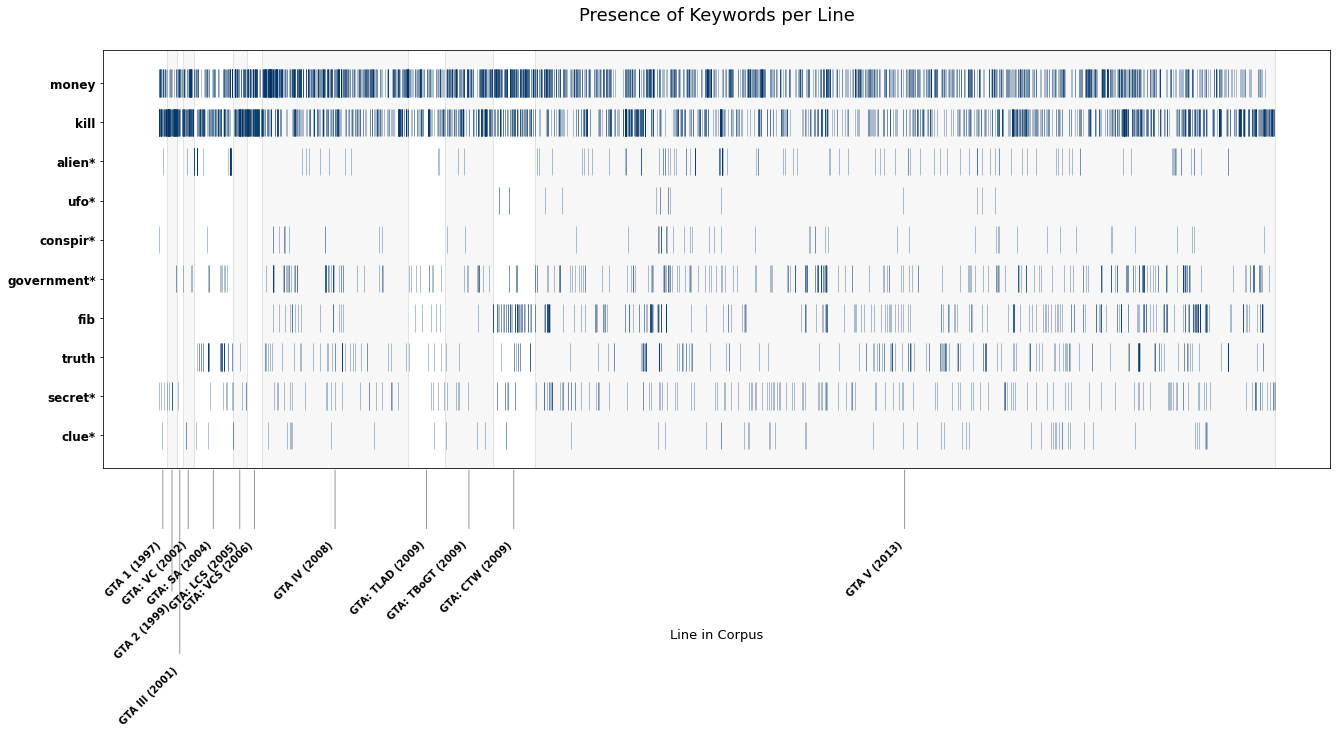

In [9]:
def run_barcode_words(df, target_words):
    """
    Creates a barcode of conspiracy categories by keywords.
    """

    # Order
    df_filtered = df[df['Game'].isin(ordered_games)].copy()
    df_filtered['Sort_Order'] = df_filtered['Game'].apply(lambda x: ordered_games.index(x))
    df_sorted = df_filtered.sort_values('Sort_Order').reset_index(drop = True)
    
    all_words = []
    game_boundaries = []
    current_game = None
    
    for i, row in df_sorted.iterrows():
        game = row['Game']
        if game != current_game:
            game_boundaries.append({'start': len(all_words), 'name': game})
            current_game = game
        
        tokens = re.findall(r'\b[a-zA-Z-]{2,}\b', str(row['Text']).lower())
        all_words.extend(tokens)
    
    total_len = len(all_words)
    
    # Set up graph
    fig, ax = plt.subplots(figsize = (22, 10))
    colors = ['#ffffff', '#f7f7f7']
    
    # Draw background and labels
    for i, boundary in enumerate(game_boundaries):
        start = boundary['start']
        end = game_boundaries[i + 1]['start'] if i + 1 < len(game_boundaries) else total_len
        short_name = short_names_map.get(boundary['name'], boundary['name'])
        
        ax.axvspan(start, end, facecolor = colors[i % 2], alpha = 1.0, zorder = 0)
        ax.axvline(x = end, color = '#dddddd', lw = 0.8, zorder = 1)
        
        if i == 0: drop_depth = -0.15
        elif i == 1: drop_depth = -0.30
        elif i == 2: drop_depth = -0.45
        else: drop_depth = -0.15
        
        mid = start + (end - start) / 2
        ax.annotate('', xy = (mid, 0), xycoords = ('data', 'axes fraction'),
                    xytext = (mid, drop_depth), textcoords = ('data', 'axes fraction'),
                    arrowprops = dict(arrowstyle = '-', color = '#999999', lw = 1))
        
        ax.text(mid, drop_depth - 0.02, short_name, transform = ax.get_xaxis_transform(),
                rotation = 45, ha = 'right', va = 'top', fontsize = 10, fontweight = 'bold')

    # Draw bars
    for idx, word in enumerate(reversed(target_words)):
        pattern = wildcard_to_regex(word)
        indices = [j for j, w in enumerate(all_words) if pattern.match(w)]
        
        # Plot all hits for a keyword as vertical lines
        ax.vlines(indices, idx - 0.35, idx + 0.35,
                  colors = '#003366', alpha = 0.6, linewidth = 0.5, zorder = 2)
    
    # Set style
    ax.set_yticks(range(len(target_words)))
    ax.set_yticklabels(reversed(target_words), fontsize = 12, fontweight = 'bold')
    ax.set_xticks([])
    
    ax.set_title('Presence of Keywords per Line', fontsize = 18, pad = 30)
    ax.set_xlabel('Line in Corpus', fontsize = 13, labelpad = 160)
    
    plt.subplots_adjust(bottom = 0.3)
    plt.savefig('conspiracy_gta_barcode_keywords.png', dpi = 300, bbox_inches = 'tight')
    
    print("Graph saved as 'conspiracy_gta_barcode_keywords.png'.")

# Set keywords
barcode_keywords = ["money", "kill", "alien*", "ufo*", "conspir*", "government*", "fib", "truth", "secret*", "clue*"]

# Execute
if 'df_master' in locals():
    run_barcode_words(df_master, barcode_keywords)